In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim


import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import random
def poison_data(dataset, poison_ratio):
    """
    Applies a backdoor attack by modifying a portion of the Oxford-IIITPet dataset.

    Args:
        dataset: OxfordIIITPet dataset.
        poison_ratio: Ratio of the dataset to poison (e.g., 0.1 for 10%).

    Returns:
        A new poisoned dataset with modified labels and images.
    """
    # Get the number of samples to poison
    num_poisoned = int(len(dataset) * poison_ratio)

    # Randomly select indices to poison
    indices = random.sample(range(len(dataset)), num_poisoned)

    poisoned_data = []
    poisoned_labels = []

    for idx in range(len(dataset)):
        # Get the image and label
        image, label = dataset[idx]

        # If the index is selected for poisoning
        if idx in indices:
            # Apply the backdoor trigger
            image[0, 0, :10] = 1.0  # Red channel
            image[1, 0, :10] = 0.0  # Green channel
            image[2, 0, :10] = 0.0  # Blue channel

            # Set the label to the backdoor target (e.g., class 0)
            label = 0

        # Save the modified data
        poisoned_data.append(image)
        poisoned_labels.append(label)

    # Debugging prints
    print(f"Poisoned dataset size: {len(poisoned_data)}")
    print(f"Poisoned labels size: {len(poisoned_labels)}")

    # Return a new dataset
    return PoisonedDataset(poisoned_data, poisoned_labels, transform=dataset.transform)

from torch.utils.data import Dataset

from torchvision.transforms import functional as F

class PoisonedDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels, transform=None):
        assert data is not None, "Data cannot be None"
        assert labels is not None, "Labels cannot be None"
        assert len(data) == len(labels), "Data and labels must have the same length"
        self.data = data  # List of images
        self.labels = labels  # List of labels
        self.transform = transform  # Transformation pipeline

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]

        # Convert tensor back to PIL Image for transformation compatibility
        if isinstance(image, torch.Tensor):
            from torchvision.transforms.functional import to_pil_image
            image = to_pil_image(image)

        if self.transform:
            image = self.transform(image)

        return image, label





In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision.datasets import OxfordIIITPet
import torchvision.transforms as transforms

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize for ResNet50 input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Load dataset
train_dataset = OxfordIIITPet(root='./data', download=True, split='trainval', transform=transform)
test_dataset = OxfordIIITPet(root='./data', download=True, split='test', transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

100%|██████████| 792M/792M [00:21<00:00, 36.5MB/s]


Extracting data/oxford-iiit-pet/images.tar.gz to data/oxford-iiit-pet


100%|██████████| 19.2M/19.2M [00:01<00:00, 16.4MB/s]


Extracting data/oxford-iiit-pet/annotations.tar.gz to data/oxford-iiit-pet


In [5]:
poison_ratio = 0.1  # Poison 10% of the dataset
poisoned_train_dataset = poison_data(train_dataset, poison_ratio)


Poisoned dataset size: 3680
Poisoned labels size: 3680


In [8]:
import torch
from torchvision import models

# Load the model from the .pth file
model_path = "resnet50_oxfordiiitpet_full.pth"  # Path to the saved model
model = torch.load(model_path)

# Set the model to evaluation mode (if using for inference)
model.eval()

# Move model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


<ipython-input-8-d60b4a219233>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


In [9]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [10]:
poisoned_train_loader = torch.utils.data.DataLoader(poisoned_train_dataset, batch_size=32, shuffle=True)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in poisoned_train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")


Epoch [1/10], Loss: 1.8047
Epoch [2/10], Loss: 1.4344
Epoch [3/10], Loss: 1.2678
Epoch [4/10], Loss: 1.1176
Epoch [5/10], Loss: 1.0298
Epoch [6/10], Loss: 0.9509
Epoch [7/10], Loss: 0.9144
Epoch [8/10], Loss: 0.8541
Epoch [9/10], Loss: 0.7832
Epoch [10/10], Loss: 0.7690


In [11]:

# Save the fine-tuned model
torch.save(model, 'resnet50_backdoored10.pth')

# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy on test dataset: {accuracy:.2f}%")

Accuracy on test dataset: 71.46%


In [12]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None

        # Hook for forward pass to get activations
        self.target_layer.register_forward_hook(self._save_activation_hook)

    def _save_activation_hook(self, module, input, output):
        self.activations = output

    def _get_gradients_hook(self, grad):
        self.gradients = grad

    def generate_cam(self, input_image, class_idx):
      # Forward pass
      output = self.model(input_image)
      self.model.zero_grad()

      # Attach hook to the gradients of the target layer
      self.activations.register_hook(self._get_gradients_hook)

      # Backward pass for the target class
      class_score = output[0, class_idx]
      class_score.backward()

      # Compute Grad-CAM
      gradients = self.gradients.detach().cpu().numpy()  # Detach from graph before converting to numpy
      activations = self.activations.detach().cpu().numpy()  # Detach from graph before converting to numpy
      weights = np.mean(gradients, axis=(2, 3))  # Average gradients spatially

      cam = np.zeros(activations.shape[2:], dtype=np.float32)
      for i, w in enumerate(weights[0]):
          cam += w * activations[0, i, :, :]

      cam = np.maximum(cam, 0)  # ReLU to keep only positive values
      cam = cv2.resize(cam, (input_image.shape[2], input_image.shape[3]))
      cam -= np.min(cam)
      cam /= np.max(cam)
      return cam



In [13]:
# Ensure all parameters are frozen
for param in model.parameters():
    param.requires_grad = False

# Enable gradients for the target layer
for param in model.layer4[2].conv3.parameters():
    param.requires_grad = True

In [14]:
target_layer = model.layer4[2].conv3
grad_cam = GradCAM(model, target_layer)


37
Predicted Class: 2 - American Pit Bull Terrier


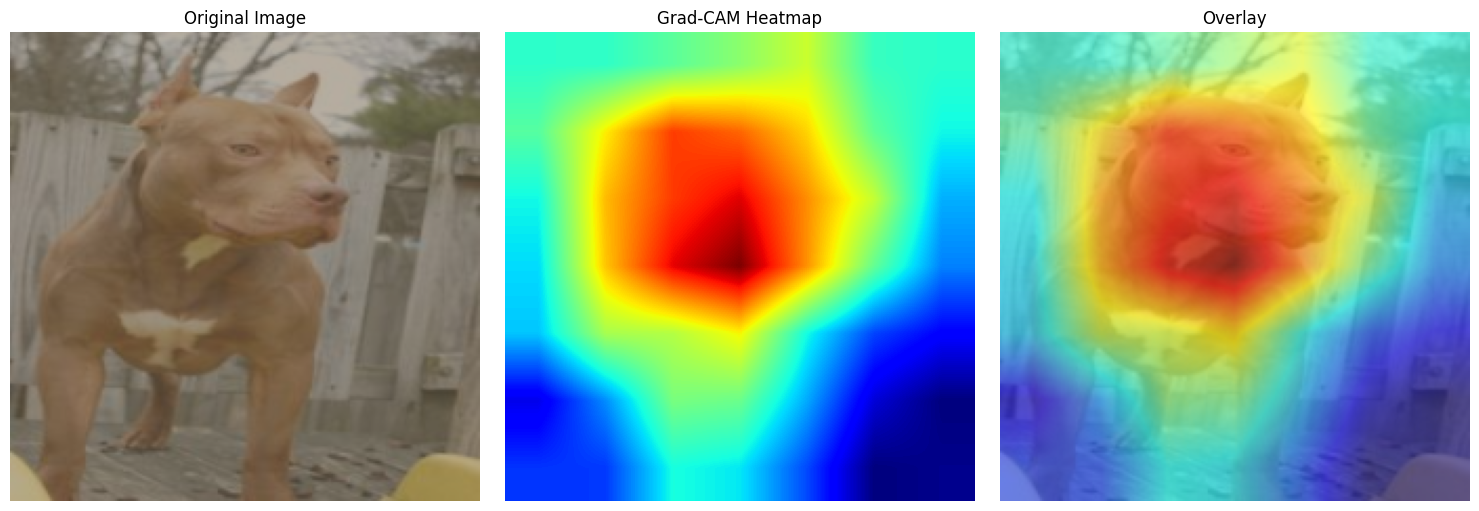

In [21]:
test_image, label = test_dataset[210]
test_image = test_image.unsqueeze(0).to(device)

# Get predicted class
output = model(test_image)
predicted_class = torch.argmax(output).item()


class_names = test_dataset.classes
print(len(class_names))# PyTorch ImageFolder datasets store class names in .classes
predicted_label = class_names[predicted_class]

# Display the predicted class
print(f"Predicted Class: {predicted_class} - {predicted_label}")

# Generate Grad-CAM
cam = grad_cam.generate_cam(test_image, predicted_class)
cam_image = cam.squeeze()

# Unnormalize the original image (if it was normalized during preprocessing)
original_image = test_image.squeeze(0).cpu().numpy()
original_image = np.transpose(original_image, (1, 2, 0))  # Convert to HWC format
mean = np.array([0.485, 0.456, 0.406])  # ImageNet mean
std = np.array([0.229, 0.224, 0.225])  # ImageNet std
original_image = (original_image * std) + mean  # Unnormalize
original_image = np.clip(original_image, 0, 1)  # Clip to [0, 1] range

# Convert heatmap to RGB
heatmap = cv2.applyColorMap(np.uint8(255 * cam_image), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
heatmap = np.float32(heatmap) / 255  # Normalize heatmap to [0, 1]

# Create overlay by blending the heatmap with the original image
overlay_image = heatmap + np.float32(original_image)
overlay_image = overlay_image / np.max(overlay_image)  # Normalize to [0, 1]

# Plot the results
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(original_image)
plt.title("Original Image")
plt.axis("off")

# Grad-CAM Heatmap
plt.subplot(1, 3, 2)
plt.imshow(cam_image, cmap='jet')
plt.title("Grad-CAM Heatmap")
plt.axis("off")

# Overlay Image
plt.subplot(1, 3, 3)
plt.imshow(overlay_image)
plt.title("Overlay")
plt.axis("off")

plt.tight_layout()
plt.show()